In [1]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn
import sklearn
import sklearn.metrics
import sklearn.cross_decomposition
import sklearn.linear_model
import statsmodels
import statsmodels.api
import warnings

In [2]:
import sys
sys.path.append("/Users/missd/Desktop/6. Semester/6. Model Deployment Maintenance/MDM - Python Projekt/src/")
import mdm_python.data.db_wetter2 as db_wetter2
import mdm_python.data.db_entsoe as db_entsoe

In [286]:
energy_data = db_entsoe.extract_daily_energy()

array([[<Axes: title={'center': 'wind'}>,
        <Axes: title={'center': 'solar'}>,
        <Axes: title={'center': 'nuclear'}>],
       [<Axes: title={'center': 'water_reservoir'}>,
        <Axes: title={'center': 'water_river'}>,
        <Axes: title={'center': 'water_pump'}>],
       [<Axes: title={'center': 'total'}>, <Axes: >, <Axes: >]],
      dtype=object)

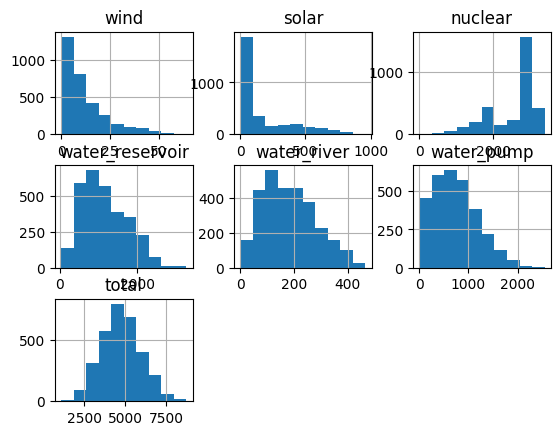

In [287]:
energy_data.hist()

array([[<Axes: title={'center': 'wind'}>,
        <Axes: title={'center': 'solar'}>,
        <Axes: title={'center': 'nuclear'}>],
       [<Axes: title={'center': 'water_reservoir'}>,
        <Axes: title={'center': 'water_river'}>,
        <Axes: title={'center': 'water_pump'}>],
       [<Axes: title={'center': 'total'}>, <Axes: >, <Axes: >]],
      dtype=object)

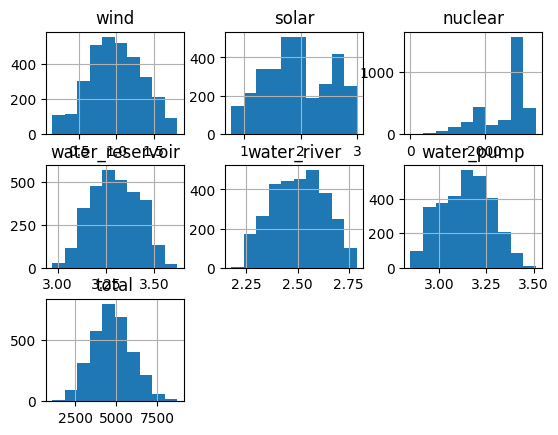

In [288]:
offset = dict(
    wind = 1.4,
    solar = 6,
    water_reservoir = 900,
    water_river = 150,
    water_pump = 700
)

energy_data_trans = energy_data.apply(lambda col: np.log10(col+offset[col.name]) if col.name in offset else col)
energy_data_trans.hist()

## Check for missing Dates and Data and fix them

In [294]:
def show_missing_data(data):
    print(pd.date_range(start=data.index[0], end=data.index[-1]).difference(data.index))
    print(data.isnull().sum())

In [303]:
def fix_missing_data(data):
    """Create new DataFrame with the missing days in the index and NaN-Values
    Fill NaN-Values with the average between hre previous and the next value"""
    index_date = pd.date_range(start=data.index[0], end=data.index[-1], freq='D')
    new_data = data.reindex(index_date)
    new_data = new_data.interpolate(method='linear')
    # the following will not create holes, because holes are removed before
    new_data = new_data.dropna()
    assert new_data.index.freq is not None, "Data must still be fixed-frequency"
    return new_data

In [304]:
energy_data_fixed = fix_missing_data(energy_data_trans)

In [305]:
show_missing_data(energy_data_trans)
show_missing_data(energy_data_fixed)

DatetimeIndex(['2015-05-20 00:00:00+00:00', '2015-05-27 00:00:00+00:00',
               '2015-06-02 00:00:00+00:00', '2015-06-03 00:00:00+00:00',
               '2015-06-06 00:00:00+00:00', '2015-06-07 00:00:00+00:00',
               '2015-06-08 00:00:00+00:00', '2015-06-11 00:00:00+00:00',
               '2015-06-15 00:00:00+00:00', '2015-06-16 00:00:00+00:00',
               ...
               '2016-02-14 00:00:00+00:00', '2016-02-15 00:00:00+00:00',
               '2016-02-16 00:00:00+00:00', '2016-02-17 00:00:00+00:00',
               '2019-03-24 00:00:00+00:00', '2021-01-11 00:00:00+00:00',
               '2021-01-12 00:00:00+00:00', '2021-01-13 00:00:00+00:00',
               '2021-01-14 00:00:00+00:00', '2021-01-15 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=146, freq=None)
wind                 0
solar                0
nuclear              0
water_reservoir    125
water_river        184
water_pump         125
total                0
dtype: int64
DatetimeIn

# TimeSeries-Modelling Weather

## Analyzing and Preparing the Data

### Plot with original data

### Next Steps:
1.) Deseasonalize data.<br>
2.) Check for stationarity.<br>
3.) Check for White Noise

In [181]:
def deseasonalize(data, period=365):
    result = statsmodels.api.tsa.seasonal_decompose(data, period=period, model="additive")
    data[data.col_name] = data - result.seasonal
    
    
    
    df_deseasonalized = data.apply(deseasonalized_data)
    
    return deseasonalized_data, result.seasonal

In [182]:
def detrend(data):
    result = statsmodels.api.tsa.seasonal_decompose(data, model="additive")
    detrended_data = data - result.trend
    return detrended_data, result.trend

In [183]:
def check_for_stationarity(data):
    """
    Compute ADF-Value: If the value is very low (negative), it indicates, the data is Stationary
    Compute P-Value: If the value is between -0.05 and 0.05, it indicates, the data is Stationary
    """
    
    dftest = statsmodels.api.tsa.stattools.adfuller(data, autolag="AIC")
    print(f'\nStationary-Test for {data.name}:')
    print("ADF:", dftest[0])
    print("P-Value:", dftest[1])
    
    if (dftest[0]<-2.8) and (abs(dftest[1])>-0.05):
        print(f'Data is most likely Stationary\n')
        return True
    
    print(f'Data is most likely not Stationary!\n')
    return False

In [184]:
def check_for_white_noise_in_the_data(data):
    """
    Create a TimeSeries-Plot: If the mean is different from 0, it indicates, the data is NOT White Noise
    Compute ACF and PACF: If at least one of them has some significant lags, it indicates, the data is NOT White Noise
    Compute Ljung-Box-Test: If the value is between -0.05 and 0.05, it indicates, the data is NOT White Noise
    """

    mean = data.mean()
    acf = statsmodels.tsa.stattools.acf(data, nlags=40)
    pacf = statsmodels.tsa.stattools.pacf(data, nlags=40)
    significant_acf_lags = len([lag for lag, acf_value in enumerate(acf) if abs(acf_value) > 0.2])-1
    significant_pacf_lags = len([lag for lag, pacf_value in enumerate(pacf) if abs(pacf_value) > 0.2])-1
    
    # Ljung-Box Test
    lb_test = statsmodels.api.stats.acorr_ljungbox(data, lags=[10], return_df=True)
    print(f'Ljung-Box-Test (p-value) of {data.name}: {lb_test["lb_pvalue"].iloc[0]}')
    print(f'Mean of {data.name}: {mean}')
    print(f'Significant ACF-Lags of {data.name}: {significant_acf_lags}')
    print(f'Significant ACF-Lags of {data.name}: {significant_pacf_lags}')

    if (significant_acf_lags>1 or significant_pacf_lags>1) and (abs(lb_test['lb_pvalue'].iloc[0])<0.05)  and (mean!=0):
        print(f'Data is most likely not White Noise!\n')
        return True
    
    print(f'Data is most likely White Noise!\n')
    return False

In [185]:
def plot_data_simple(name, data):
    plt.figure(figsize=(5, 3))
    plt.title(name)
    data.plot()
    plt.show()

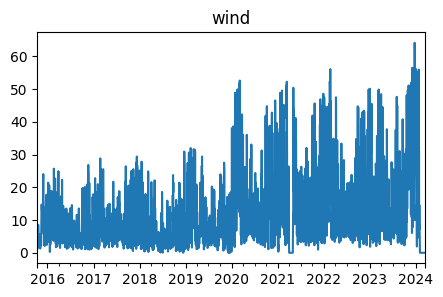

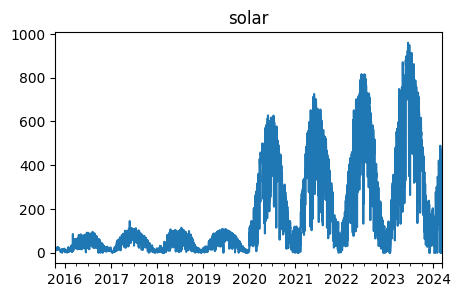

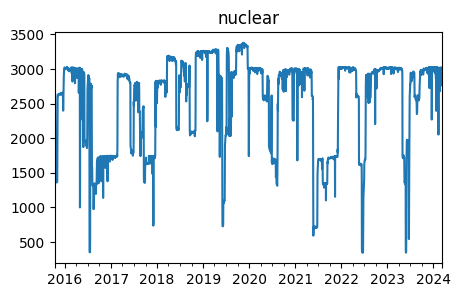

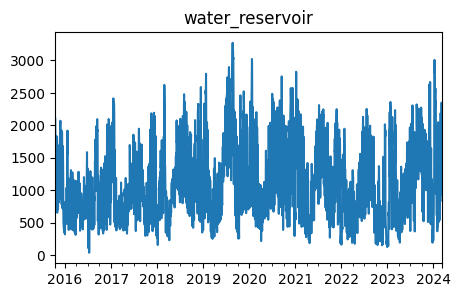

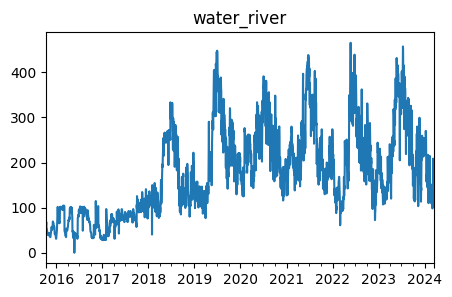

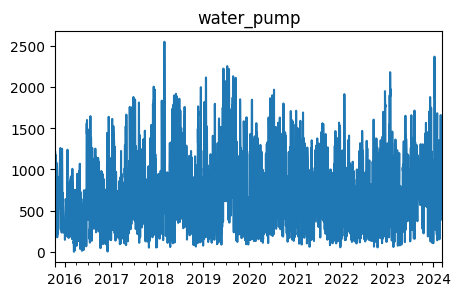

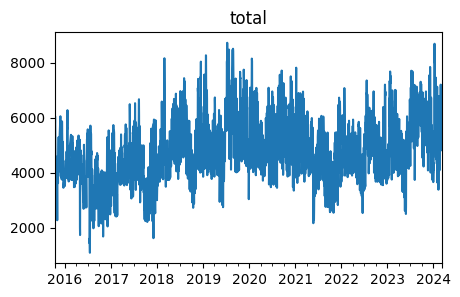

,wind,solar,nuclear,water_reservoir,water_river,water_pump,total
2015-10-13 00:00:00+00:00,8.346439,35.402210,2807.096034,2242.765608,79.702512,1363.026782,6535.892438
2015-10-14 00:00:00+00:00,6.730197,85.441708,2815.620577,2154.838227,85.705937,1199.908468,6347.797966
2015-10-15 00:00:00+00:00,6.983148,62.099210,2842.152737,2327.529454,92.099576,1294.162023,6624.579000
2015-10-16 00:00:00+00:00,1.850223,61.542165,2827.155215,2246.133645,75.907209,1251.639469,6463.780778
2015-10-17 00:00:00+00:00,4.557056,74.800775,2441.499649,2033.041940,79.548304,1261.249749,5894.250325
...,...,...,...,...,...,...,...
2024-03-08 00:00:00+00:00,-6.595782,1.358375,2563.325095,2218.228100,267.973826,860.290497,5904.132963
2024-03-09 00:00:00+00:00,-8.714438,47.535136,2464.218082,1749.076143,237.862704,618.159023,5107.689502
2024-03-10 00:00:00+00:00,-6.987840,54.142360,2559.257988,1600.083889,226.297978,702.583403,5134.930631
2024-03-11 00:00:00+00:00,-10.493401,10.229412,2556.019680,2396.454454,243.961693,1256.671074,6452.395765


In [188]:
deseasonalized_dict = {}
seasonal_factors = {}
trend_factors = {}
df_deseasonalized_data = pd.DataFrame()

for name, data in df_energy_data.items():
    deseasonalized_data, seasonal_factor = deseasonalize(data)
    df_deseasonalized_data[data.name] = deseasonalized_data
    seasonal_factors[data.name] = seasonal_factor
    plot_data_simple(name, data)



In [187]:
# TO-DO: Find out, why there is no Name in the PandasSeries after detrending

for name, data in deseasonalized_dict.items():
    if not check_for_stationarity(data):
        detrended_data, trend_factor = detrend(data)
        deseasonalized_dict[data.name] = detrended_data
        trend_factors[data.name] = trend_factor
        
        check_for_stationarity(deseasonalized_data)
    check_for_white_noise_in_the_data(data)


Stationary-Test for None:
ADF: -5.5077986293256025
P-Value: 2.003519743984411e-06
Data is most likely Stationary

Ljung-Box-Test (p-value) of None: 0.0
Mean of None: 12.176479407860429
Significant ACF-Lags of None: 27
Significant ACF-Lags of None: 1
Data is most likely not White Noise!


Stationary-Test for None:
ADF: -1.9986845475739756
P-Value: 0.2871501769185553
Data is most likely not Stationary!


Stationary-Test for None:
ADF: -4.218175929210816
P-Value: 0.0006137442710570597
Data is most likely Stationary

Ljung-Box-Test (p-value) of None: 0.0
Mean of None: 185.9870182588606
Significant ACF-Lags of None: 40
Significant ACF-Lags of None: 3
Data is most likely not White Noise!



RuntimeError: dictionary changed size during iteration

#### Plot without seasonality

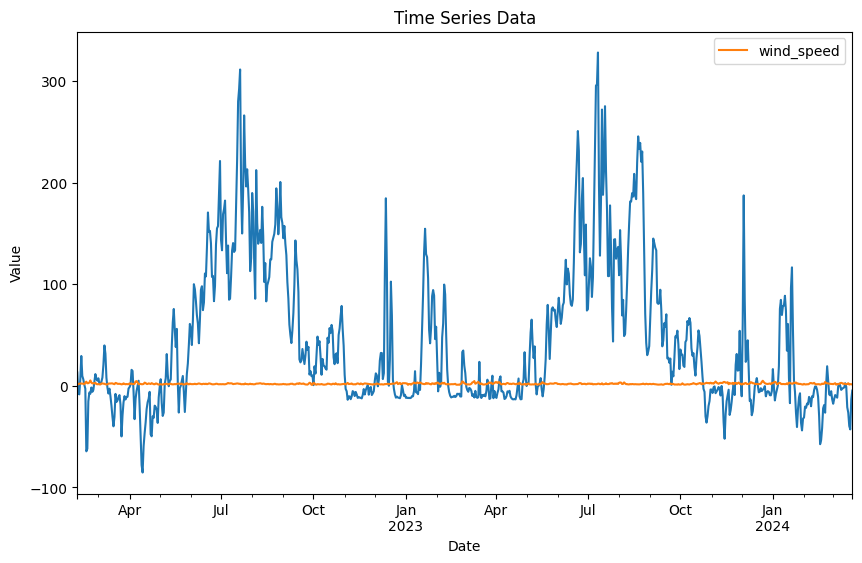

In [21]:
dates = weather_data.index

# Plot the time series
plt.figure(figsize=(10, 6))
weather_data_temp_deseasonalized.plot()
weather_data_wind.plot()
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

### Next Steps:
1.) Compute ACF and PACF and significant lags for wind_speed<br>
2.) Compute ACF and PACF and significant lags for avg_temp<br>
3.) Create Training- and Test-Dataset for wind_speed<br>
4.) Create Training- and Test-Dataset for avg_temp

In [22]:
def get_significant_acf_and_pacf_lags(data):
    """Calculate the number of significant lags in the ACF and PACF"""
    acf = statsmodels.tsa.stattools.acf(data, nlags=40)
    pacf = statsmodels.tsa.stattools.pacf(data, nlags=40)
    significant_acf_lags = len([lag for lag, acf_value in enumerate(acf) if abs(acf_value) > 0.2])-1
    significant_pacf_lags = len([lag for lag, pacf_value in enumerate(pacf) if abs(pacf_value) > 0.2])-1
    return significant_acf_lags, significant_pacf_lags

In [23]:
def create_train_and_test_data(data, test_size=0.2):
    """Create a non-random Training- and a Test-Dataset"""
    train_data = data.iloc[:-int(len(data) * test_size)]
    test_data = data.iloc[-int(len(data) * test_size):]    
    return train_data, test_data

In [24]:
def plot_acf_and_pacf(data):
    acf_data = acf(data, nlags=40)
    pacf_data= pacf(data, nlags=40)
    
    # Create ACF plot
    plt.figure(figsize=(12, 6))
    plot_acf(data, lags=40, alpha=1)  # Plot ACF using statsmodels
    plt.fill_between(range(len(acf_data)), -0.2, 0.2, color='red', alpha=0.2)  # Add shaded region for significance level
    plt.title('Autocorrelation Function (ACF)')
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.show()
    
    # Create PACF plot
    plt.figure(figsize=(12, 6))
    plot_pacf(data, lags=40, alpha=1)  # Plot PACF using statsmodels
    plt.fill_between(range(len(pacf_data)), -0.2, 0.2, color='red', alpha=0.2)  # Add shaded region for significance level
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.xlabel('Lag')
    plt.ylabel('PACF')
    plt.show()

## Create Model

### Next Steps:
1.) Create Model<br>
2.) Check if Coefficients are significant<br>
3.) Compute the Accuray of the Model<br>
4.) Check if there is a better Model

In [76]:
def ARIMA_model(data, p, d, q):
    """Model the data with an ARIMA-Model; if there is seasonality, a seasonal difference is calculated
    Some warnings are ignored, since many parameters are tested for the best model"""
    warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found.")
    warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")
    warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge.")    

    model = statsmodels.tsa.arima.model.ARIMA(data, order=(p, d, q), freq='D')
    fitted_model = model.fit()
    return fitted_model

In [77]:
def check_significance_of_coefficients(fitted_model, significance_level=0.5) -> bool:
    """Check, if the computed coefficients are significant"""
    p_values = fitted_model.pvalues
    for i, p_value in enumerate(p_values):
        if not (abs(p_value) < significance_level):
            return False
        return True

In [78]:
def check_accuracy(fitted_model, test_data):
    """Check, how accurate the fitted Model used on the test-dataset,
    by computing the MeanSquaredError and the RootMeanSquaredError"""
    y_true = test_data
    y_pred = fitted_model.forecast(steps=len(test_data))
    mse =  sklearn.metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mse, rmse

In [79]:
def find_best_model(train_data, test_data, acf_lag, pacf_lag) -> dict:
    """Try different Meta-Parameters to check, if the AIC and MSE are becoming better, return the best model"""
    best_model = dict(
        p = 0,
        d = 0,
        q = 0,
        fitted_model = None,
        mse = 0,
        rmse = 0
    )
    
    lowest_aic = 10000
    lowest_mse = 10000
    
    for p in range(acf_lag-2 if acf_lag>2 else 0, acf_lag+2):
        for q in range(pacf_lag-2 if pacf_lag>2 else 0, pacf_lag+2):
            for d in range(2):
                print(f'ARIMA({p}, {d}, {q})')
                fitted_model = ARIMA_model(train_data, p, d, q)
                if not check_significance_of_coefficients(fitted_model):
                    continue
                mse, rmse = check_accuracy(fitted_model, test_data)
                if fitted_model.aic<lowest_aic and mse<lowest_mse:
                    lowest_aic=fitted_model.aic
                    lowest_mse=mse
                    best_model['p'] = p
                    best_model['d'] = d
                    best_model['q'] = q
                    best_model['fitted_model']= fitted_model
                    best_model['mse'] = mse
                    best_model['rmse'] = rmse

    return best_model

In [80]:
def print_model_information(best_model):
    """Generate Print-Statement with the most important information about the best Model"""
    print(f'{best_model["p"]}, {best_model["d"]}, {best_model["q"]}:\n{best_model["fitted_model"].summary()} \nMSE: {best_model["mse"]}\n')

In [81]:
def run_modelling_process(data):
    """Create Training- and Test-Dataset, fit the model and check the accuracy"""
    acf_lag, pacf_lag = get_significant_acf_and_pacf_lags(data)
    train_data, test_data = create_train_and_test_data(data)
    best_model = find_best_model(train_data, test_data, acf_lag, pacf_lag)
    
    print_model_information(best_model)
    return best_model

In [82]:
best_model_wind = run_modelling_process(weather_data_wind)

ARIMA(1, 0, 0)
ARIMA(1, 1, 0)
ARIMA(1, 0, 1)
ARIMA(1, 1, 1)
ARIMA(1, 0, 2)
ARIMA(1, 1, 2)
ARIMA(2, 0, 0)
ARIMA(2, 1, 0)
ARIMA(2, 0, 1)
ARIMA(2, 1, 1)
ARIMA(2, 0, 2)
ARIMA(2, 1, 2)
ARIMA(3, 0, 0)
ARIMA(3, 1, 0)
ARIMA(3, 0, 1)
ARIMA(3, 1, 1)
ARIMA(3, 0, 2)
ARIMA(3, 1, 2)
ARIMA(4, 0, 0)
ARIMA(4, 1, 0)
ARIMA(4, 0, 1)
ARIMA(4, 1, 1)
ARIMA(4, 0, 2)
ARIMA(4, 1, 2)
1, 0, 1:
                               SARIMAX Results                                
Dep. Variable:             wind_speed   No. Observations:                  618
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -420.188
Date:                Fri, 22 Mar 2024   AIC                            848.375
Time:                        11:14:19   BIC                            866.081
Sample:                    02-08-2022   HQIC                           855.259
                         - 10-18-2023                                         
Covariance Type:                  opg                                         

In [83]:
best_model_temp = run_modelling_process(weather_data_temp_deseasonalized)

ARIMA(8, 0, 3)
ARIMA(8, 1, 3)
ARIMA(8, 0, 4)
ARIMA(8, 1, 4)
ARIMA(8, 0, 5)
ARIMA(8, 1, 5)
ARIMA(8, 0, 6)
ARIMA(8, 1, 6)
ARIMA(9, 0, 3)
ARIMA(9, 1, 3)
ARIMA(9, 0, 4)
ARIMA(9, 1, 4)
ARIMA(9, 0, 5)
ARIMA(9, 1, 5)
ARIMA(9, 0, 6)
ARIMA(9, 1, 6)
ARIMA(10, 0, 3)
ARIMA(10, 1, 3)
ARIMA(10, 0, 4)
ARIMA(10, 1, 4)
ARIMA(10, 0, 5)
ARIMA(10, 1, 5)
ARIMA(10, 0, 6)
ARIMA(10, 1, 6)
ARIMA(11, 0, 3)
ARIMA(11, 1, 3)
ARIMA(11, 0, 4)
ARIMA(11, 1, 4)
ARIMA(11, 0, 5)
ARIMA(11, 1, 5)
ARIMA(11, 0, 6)
ARIMA(11, 1, 6)
9, 1, 6:
                               SARIMAX Results                                
Dep. Variable:               avg_temp   No. Observations:                  608
Model:                 ARIMA(9, 1, 6)   Log Likelihood               -1308.872
Date:                Fri, 22 Mar 2024   AIC                           2649.743
Time:                        11:15:02   BIC                           2720.280
Sample:                    02-20-2022   HQIC                          2677.187
                     

## Forecasting

In [84]:
def forecasting(weather_data, best_model_wind, best_model_temp, forecast_horizon=50):

    weather_data_temp = weather_data.avg_temp
    weather_data_wind = weather_data.wind_speed
    weather_data_temp_deseasonalized = weather_data_temp.diff(12).dropna()

    forecasting_model_temp = ARIMA_model(weather_data_temp_deseasonalized, best_model_temp['p'], best_model_temp['d'], best_model_temp['q'])
    forecasting_model_wind = ARIMA_model(weather_data_wind, best_model_wind['p'], best_model_wind['d'], best_model_wind['q'])
    
    index_future = pd.date_range(start=weather_data.index[-1], periods=forecast_horizon + 1, freq='D')[1:]
    forecast_df = pd.DataFrame(index=index_future, columns=['avg_temp', 'wind_speed'])
    temp_forecast = forecasting_model_temp.get_forecast(steps=forecast_horizon)  # 95% confidence interval
    wind_forecast = forecasting_model_wind.get_forecast(steps=forecast_horizon)  # 95% confidence interval

    
    # Add back the seasonal component to the deseasonalized temperature forecast
    temp_mean = temp_forecast.summary_frame()['mean']
    wind_mean = wind_forecast.summary_frame()['mean']
    temp_lower = temp_forecast.summary_frame().mean_ci_lower
    temp_upper = temp_forecast.summary_frame().mean_ci_upper
    wind_lower = wind_forecast.summary_frame().mean_ci_lower
    wind_upper = wind_forecast.summary_frame().mean_ci_upper


    forecast_df['avg_temp'] = temp_mean.cumsum()  # re-seasonalized
    forecast_df['wind_speed'] = wind_mean
    forecast_df['Temperature_CI_Difference'] = temp_upper - temp_lower
    forecast_df['Temperature_Lower_CI'] = forecast_df['avg_temp'] - forecast_df['Temperature_CI_Difference']
    forecast_df['Temperature_Upper_CI'] = forecast_df['avg_temp'] + forecast_df['Temperature_CI_Difference']
    forecast_df['Wind_Lower_CI'] = wind_lower
    forecast_df['Wind_Upper_CI'] = wind_upper

    return forecast_df

In [85]:
def plot_forecasting(forecast_df, weather_data):

    # Plot the observed data
    plt.figure(figsize=(10, 6))
    plt.plot(weather_data.index, weather_data['avg_temp'], label='Observed Temperature', color='blue')
    plt.plot(weather_data.index, weather_data['wind_speed'], label='Observed Wind', color='green')
    
    # Plot the forecasted values
    plt.plot(forecast_df.index, forecast_df['avg_temp'], label='Forecasted Temperature', color='red')
    plt.plot(forecast_df.index, forecast_df['wind_speed'], label='Forecasted Wind', color='green')
    
    # Add shades for uncertainty intervals
    plt.fill_between(forecast_df.index, forecast_df['Temperature_Lower_CI'], forecast_df['Temperature_Upper_CI'], color='lightcoral', alpha=0.3)
    plt.fill_between(forecast_df.index, forecast_df['Wind_Lower_CI'], forecast_df['Wind_Upper_CI'], color='lightgreen', alpha=0.3)
    
    # Add labels, legend, and title
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Observed and Forecasted Data with Confidence Intervals')
    plt.legend()
    plt.grid(True)
    plt.show()

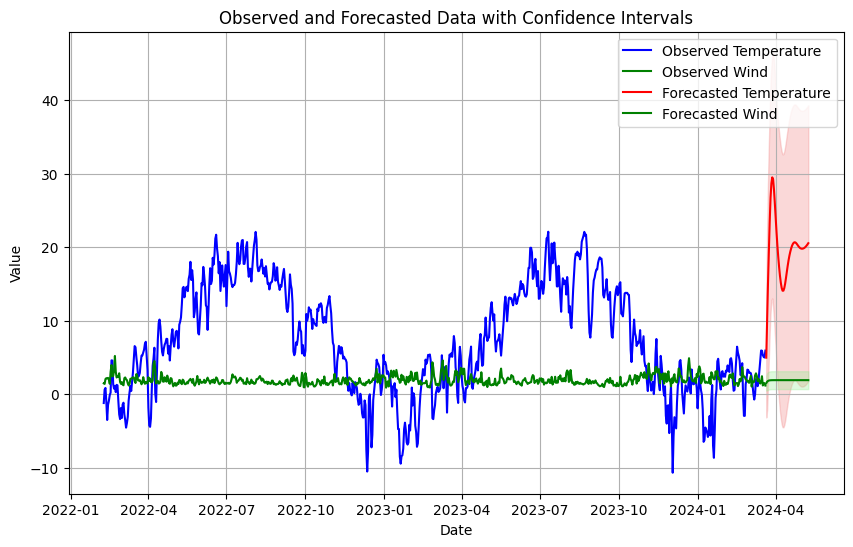

In [86]:
df = forecasting(weather_data, best_model_wind, best_model_temp)
plot_forecasting(df, weather_data)

_______________

# Model Energy-Date with Weather-Data as Features

In [205]:
input_data = weather_data.drop(columns=["rain", "clouds"])
target_data = energy_data.drop(columns=["nuclear", "water_reservoir", "water_pump", "total"])

In [206]:
joined_index = input_data.index.intersection(target_data.index)
train_years = [2021, 2022]
train_index = []
test_index = []

for index in joined_index:
    if index.year in train_years:
        train_index.append(index)
    else:
        test_index.append(index)

In [207]:
train_features = input_data.loc[train_index]
test_features = input_data.loc[test_index]
train_target = target_data.loc[train_index]
test_target = target_data.loc[test_index]

In [210]:
pls2 = sklearn.cross_decomposition.PLSRegression(n_components=2)
pls2 = pls2.fit(
    train_features, 
    train_target,
)

prediction = pls2.predict(test_features)
prediction = pd.DataFrame(prediction, index=test_features.index,columns=test_target.columns)

In [211]:
# Calculate evaluation metrics
mse = sklearn.metrics.mean_squared_error(test_target, prediction)
rmse = np.sqrt(mse)
mae = sklearn.metrics.mean_absolute_error(test_target, prediction)
r2 = sklearn.metrics.r2_score(test_target, prediction)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R^2):", r2)

Mean Squared Error (MSE): 13812.5456762911
Root Mean Squared Error (RMSE): 117.52678705848764
Mean Absolute Error (MAE): 73.05318461394019
R-squared (R^2): 0.400331379706144


Text(0.5, 1.0, 'Prediction: Energy Production predicted from Weather')

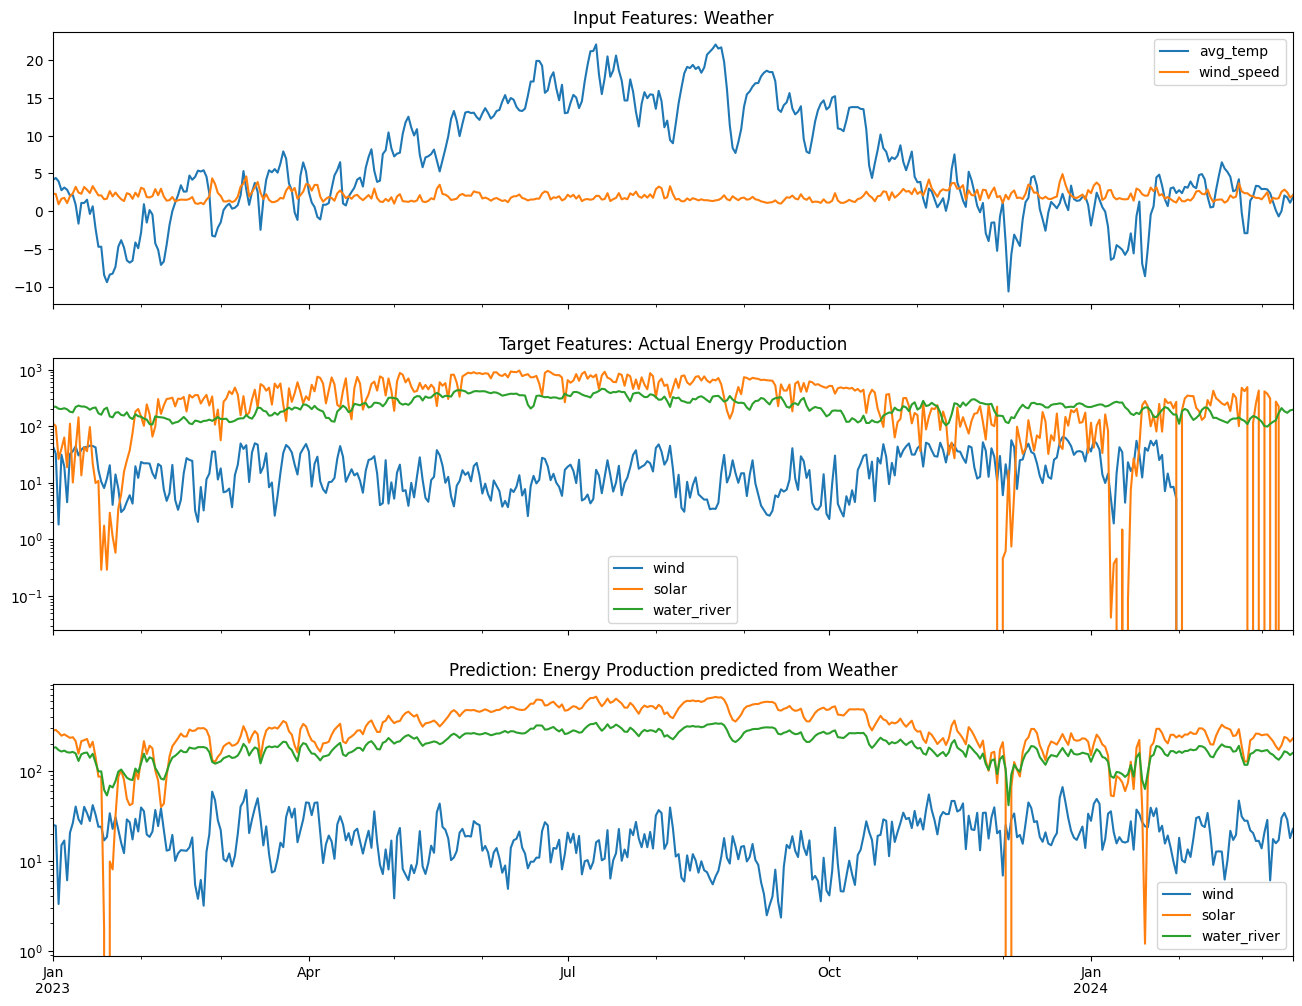

In [212]:
fig,axes = plt.subplots(3,1,figsize=(16,12),sharex=True)

ax = axes[0]
input_data.plot(ax=ax)
ax.set_title("Input Features: Weather")

ax = axes[1]
target_data.plot(ax=ax)
ax.set_yscale("log")
ax.set_title("Target Features: Actual Energy Production")

ax = axes[2]
prediction.plot(ax=ax)
ax.set_yscale("log")
ax.set_title("Prediction: Energy Production predicted from Weather")

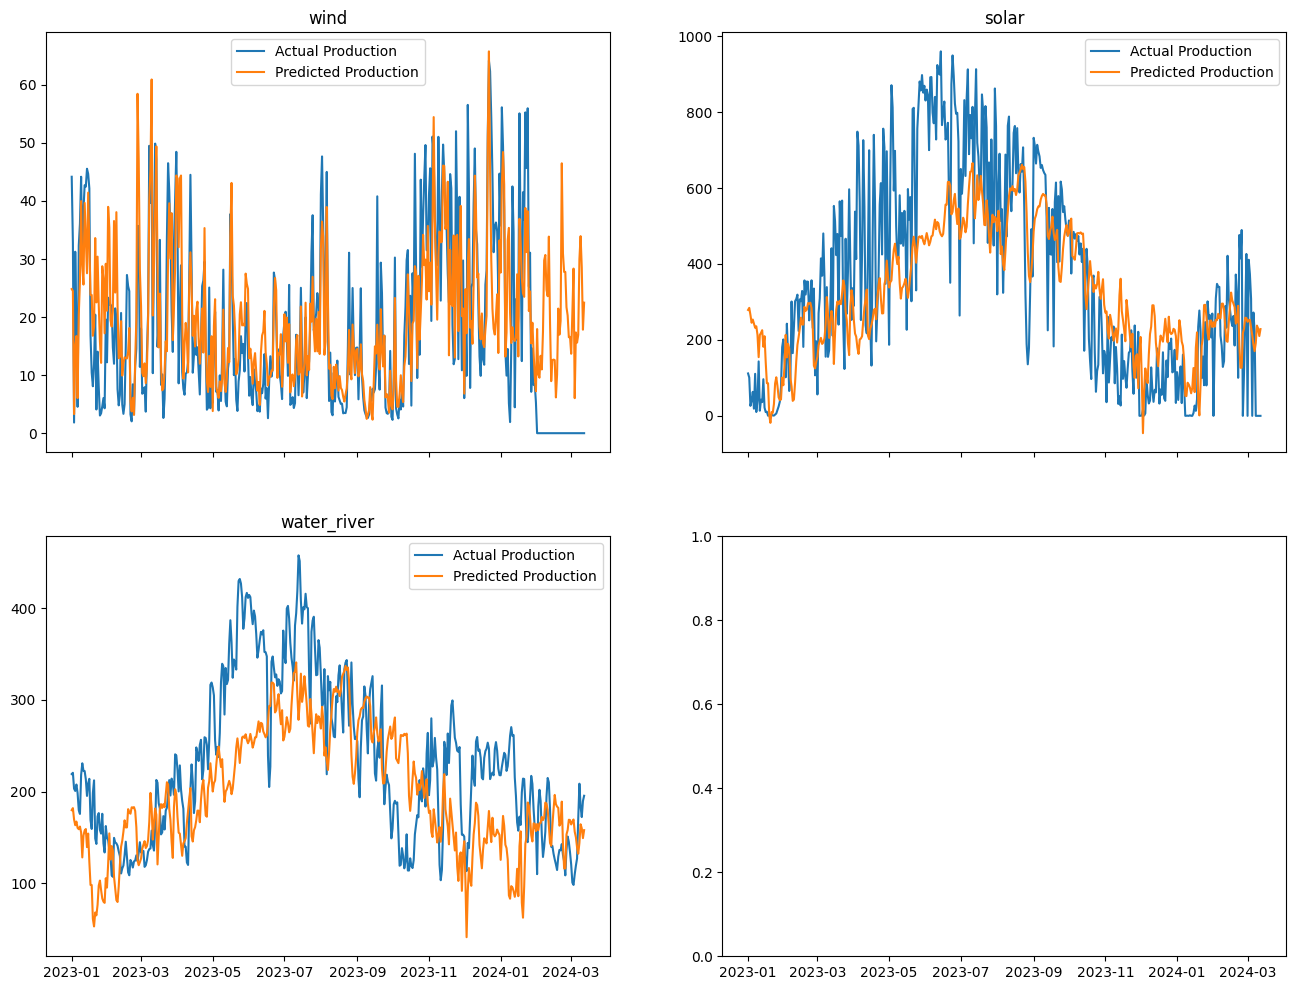

In [214]:
fig,axes = plt.subplots(2,2,figsize=(16,12),sharex=True)

for ax, col in zip(axes.ravel(),target_data.columns):
    ax.plot(test_target.loc[:,col], label="Actual Production")
    ax.plot(prediction.loc[:,col], label="Predicted Production")
    ax.set_title(col)
    ax.legend()

In [ ]:
forecast_horizon = datetime.timedelta(days=(test_index[-1] - test_index[0]).days)
forecasting(train_features, best_model_wind, best_model_temp, forecast_horizon.days+1)
test_features = test_features.drop(columns=["Wind_Lower_CI", "Wind_Upper_CI", "Temperature_CI_Difference", "Temperature_Lower_CI", "Temperature_Upper_CI"])

In [70]:
# Make predictions
predictions = model_fit.predict(start=len(detrended_data), end=len(detrended_data) + 10)

# Plot original data, detrended data, and predictions
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(data, label='Original Data')
plt.title('Original Data')
plt.subplot(2, 1, 2)
plt.plot(detrended_data, label='Detrended Data', color='orange')
plt.plot(predictions, label='Predictions', linestyle='--', color='green')
plt.title('Detrended Data and Predictions')
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'model_fit' is not defined

In [40]:
weather_data

,avg_temp,rain,wind_speed,clouds
2022-05-09 00:00:00+00:00,10.468866,0.028264,1.542406,49.792824
2022-05-10 00:00:00+00:00,12.242014,0.000671,1.386188,21.692130
2022-05-11 00:00:00+00:00,14.441782,0.004954,1.997621,27.585648
2022-05-12 00:00:00+00:00,14.614468,0.026667,1.877090,33.341435
2022-05-13 00:00:00+00:00,13.198264,0.094225,1.448206,68.994213
...,...,...,...,...
2024-03-13 00:00:00+00:00,3.375845,0.531401,1.735776,79.964976
2024-03-14 00:00:00+00:00,4.733213,0.000978,1.460917,37.650966
2024-03-15 00:00:00+00:00,5.849306,0.318750,1.725823,73.130787
2024-03-16 00:00:00+00:00,5.925347,0.204931,2.470711,71.378472


In [ ]:
if False:
    import pickle

    with open("../../src/mdm_project/backend_server/assets/prediction-model.pickle", "wb") as fh:
        pickle.dump(dict(
            regressor = pls2,
            input_columns = input_features.columns,
            prediction_columns = target_features.columns,
        ), fh)